> 해당 노트북은 [Information System Lab 의 kaggle notebook](https://www.kaggle.com/code/charalambos/xgb-of-instacart-ml-2-notebook/notebook) 을 참고해서 작성했음을 알려드립니다.

# Introduction
이 커널은 그리스 마케도니아 대학교의 학생들에게 머신 러닝 및 데이터 과학을 소개하기 위해 Information Systems Lab 에서 만들었습니다.

## The Instacart competition¶
Instacart는 당일 식료품 배송 서비스를 제공하는 미국 회사입니다. 고객이 웹 애플리케이션을 통해 다양한 소매업체의 식료품을 선택하면 퍼스널 쇼퍼가 배송합니다. Instacart의 서비스는 주로 스마트폰 앱을 통해 제공되며, 웹사이트와는 별도로 iOS 및 Android 플랫폼에서 사용할 수 있습니다.

2017년 Instacart는 Kaggle 경진대회를 개최하여 20만 명 이상의 Instacart 사용자로부터 300만 건 이상의 식료품 주문 샘플 데이터 세트를 커뮤니티에 제공했습니다. 이 주문에는 3,200만 개의 장바구니 품목과 5만 개의 고유 제품이 포함되어 있습니다. 대회 참가자들은 이전에 구매한 제품 중 어떤 제품이 다음 주문에 포함될지 예측하는 것이 목표였습니다.

## Objective
이 커널의 목적은 학생들에게 Instacart 사례를 통해 Python을 사용한 예측 비즈니스 분석을 소개하는 것입니다.

이 예제를 완료하면 다음을 수행할 수 있습니다.

* 예측 분석 모델을 만드는 단계를 설명할 수 있습니다.
* Python 및 Pandas 패키지를 사용하여 데이터 조작하기
* Python 및 Pandas 패키지를 사용하여 데이터프레임 생성, 결합 및 삭제하기
* Random Forests를 사용하여 예측 모델 만들기
* 예측 모델을 적용하여 예측하기
* 인스타카트 대회에 제출할 파일 생성하기

## Problem definition
Instacart가 개방한 데이터에는 각 사용자가 4~100개의 주문을 보유한 200,000명의 Instacart 사용자의 주문이 포함됩니다. Instacart는 데이터에서 각 주문을 이전, 훈련 또는 테스트로 표시합니다. 이전 주문은 사용자의 과거 행동을 나타내며, 훈련 및 테스트 주문은 예측해야 하는 미래 행동을 나타냅니다.

따라서 사용자의 다음 주문(훈련 및 테스트 주문)에 어떤 이전에 구매한 제품(이전 주문)이 포함될지 예측하고자 합니다.

train 주문의 경우 Instacart는 결과(즉, 주문한 제품)를 표시하지만 test 주문의 경우 이러한 정보가 없습니다. 또한 각 사용자의 향후 주문은 train 또는 test가 될 수 있으므로 각 사용자는 train 또는 test 사용자가 될 수 있습니다.

따라서 우리는 제품의 특성과 하나 또는 여러 제품에 대한 사용자의 행동을 설명할 다양한 예측 변수(X)를 생각해내고 계산해야 합니다. 데이터 세트의 이전 주문을 분석하여 이를 수행합니다. 그런 다음 훈련 사용자를 사용하여 예측 모델을 만들고 테스트 사용자를 사용하여 실제 예측을 수행합니다. 그 결과 다음과 같은 테이블을 만들고 예측 변수(X)와 반응 변수(Y)를 기반으로 알고리즘을 훈련합니다.

## Method
1. 데이터 가져오기 및 변형하기: 이 단계에는 CSV 파일을 판다 데이터 프레임에 로드하고, 문자 변수를 범주형 변수로 변환하고, 지원 테이블을 만드는 것이 포함됩니다.
2. 예측 변수 만들기: 이 단계에는 Instacart에서 제공하는 초기 데이터 세트에서 예측 변수(일명 특징)를 식별하고 계산하는 작업이 포함됩니다.
3. 훈련 및 테스트 데이터프레임 생성: 이 단계에서는 예측 모델을 생성하고 사용하는 데 사용될 두 개의 서로 다른 판다 데이터 프레임을 생성합니다.
4. 예측 모델 만들기(적합): 이 단계에서는 훈련 데이터 세트를 통해 예측 모델을 훈련합니다.
5. 예측 모델 적용(예측): 이 단계에서는 테스트 데이터 세트에 대해 '재정렬된' 변수를 예측하기 위해 모델을 적용합니다.
6. 제출 파일 생성: 이 마지막 단계에서는 Instacart의 경쟁에 대한 예측이 포함된 제출 파일을 생성합니다.
7. F1 점수 얻기: 이 단계에서는 생성된 파일을 제출하고 예측 모델의 정확도를 설명하는 F1 점수를 얻습니다.


# 1. Import and Reshape Data

In [2]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline

In [3]:
sns.set_theme()

In [25]:
order_products_train = pd.read_csv('market/order_products_train.csv')
order_products_prior = pd.read_csv('market/order_products_prior.csv')
orders = pd.read_csv('market/order.csv')
products = pd.read_csv('market/product.csv')
departments = pd.read_csv('market/department.csv')
aisles = pd.read_csv('market/aisle.csv')
submission = pd.read_csv('market/sample__submission.csv')

In [26]:
print(order_products_train.dtypes)
order_products_train.head(2)

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1


In [27]:
print(order_products_prior.dtypes)
order_products_prior.head(2)

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1


In [33]:
print(orders.dtypes)
orders.head(2)

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


In [34]:
print(products.dtypes)
products.head(2)

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13


In [35]:
print(departments.dtypes)
departments.head(2)

department_id     int64
department       object
dtype: object


,department_id,department
0,1,frozen
1,2,other


In [36]:
print(aisles.dtypes)
aisles.head(2)

aisle_id     int64
aisle       object
dtype: object


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


## Reshape data
추가 분석을 용이하게 하기 위해 데이터를 변환합니다.  
먼저, 문자 변수를 카테고리로 변환하여 모델 생성에 사용할 수 있도록 합니다.  
파이썬에서는 범주형 변수를 카테고리라고 하며 고정된 수의 다른 값을 갖습니다.

In [37]:
aisles['aisle'] = aisle['aisle'].astype('category')
departments['department'] = department['department'].astype('category')
orders['eval_set'] = order['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')


## Merge
orders 및 order_products_prior 데이터프레임을 결합(병합)하는 op이라는 이름의 새 데이터프레임을 만듭니다. order_products_prior 데이터프레임에는 이전 주문만 포함되므로 새 데이터프레임 연산에는 이러한 관측값만 포함된다는 점에 유의하세요. 이를 위해, 두 데이터 프레임 모두에서 일치하는 값을 가진 레코드를 반환하는 how='inner' 인수와 함께 pandas의 병합 함수를 사용합니다.

In [38]:
# merge (how='inner')
# order_id로 병합하고, 두 개의 DataFrame에 모두 표시되는 행만 유지
op = orders.merge(order_products_prior, on='order_id', how='inner')

In [39]:
op.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0


In [40]:
op.days_since_prior_order.unique()

array([nan, 15., 21., 29., 28., 19., 20., 14.,  0., 30., 10.,  3.,  8.,
       13., 27.,  6.,  9., 12.,  7., 17., 11.,  4.,  5.,  2., 23., 26.,
       25., 16.,  1., 18., 24., 22.])

# 2. Create Predictor Variables
이제 제공된 데이터를 기반으로 예측 변수를 식별하고 계산할 준비가 되었습니다.  
다음과 같은 다양한 유형의 예측 변수를 생성할 수 있습니다.

* 사용자의 행동을 설명하는 사용자 예측 변수(예: 사용자의 총 주문 수).
* 제품의 특성을 설명하는 제품 예측 변수(예: 제품 구매 총 횟수).
* 특정 제품에 대한 사용자의 행동을 설명하는 사용자 및 제품 예측자(예: 사용자가 특정 제품을 주문한 총 횟수).

### Create user predictors
#### 1) 고객당 주문 수 (Number of orders per customer)
고객당 총 주문 건수를 계산합니다.  
결과를 저장할 user 데이터 프레임을 생성합니다.

In [46]:
# 방법2
# Double brackets --> [[ ]]
user = op.groupby('user_id')[['order_number']].max()
user = user.rename(columns={'order_number': 'u_total_orders'})
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


#### 2) 고객당 재주문하는 제품의 빈도 (How frequent a customer has reordered products)
이 기능은 각 사용자별로 과거에 재주문한 제품이 어느 정도 있는지를 보여주는 비율입니다.

분자는 사용자가 제품을 재주문한 모든 횟수의 카운터(재주문 시 값=1)이고,  
분모는 모든 사용자의 주문에서 구매한 모든 제품의 카운터(재주문=0 & 재주문=1)입니다.

위의 비율을 생성하기 위해 각 사용자별로 .groupby() order_products_prior를 수행한 다음 재주문된 평균을 계산합니다.

In [47]:
u_reorder = op.groupby('user_id')[['reordered']].mean()
u_reorder = u_reorder.rename(columns={'reordered': 'u_reordered_ratio'})
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [48]:
# merge (how='left')
user = user.merge(u_reorder, on='user_id', how='left')

# del u_reorder
# gc.collect() <- 이건 뭔지 모르겠음...

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


### Create product predictors
#### 1) 각 제품별 구매 횟수 (Number of purchases for each product)
각 제품의 총 구매 횟수(모든 고객의 구매 횟수)를 계산합니다.   
결과를 저장하기 위해 prd 데이터 프레임을 생성합니다.

In [66]:
prd = op.groupby('product_id')[['order_id']].count()
prd = prd.rename(columns={'order_id': 'p_total_purchases'})
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


#### 2) What is the probability for a product to be reordered (제품의 재주문될 확률)


이 추정을 진행하기 전에 앞서 언급한 비율을 의미 있게 계산하기 위해 구매 횟수가 40회 미만인 제품을 모두 제거합니다.

.groupby( )를 사용하여 각 제품에 대한 그룹을 생성하고 .filter( )를 사용하여 40개 이상의 행이 있는 그룹만 유지합니다. 이를 위해 lamda 함수를 표시합니다.

In [68]:
# shape[0] on a DataFrame returns the number of rows
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >= 40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


재주문 확률을 계산하기 위해 재주문된 열에 집계 함수 평균()을 사용합니다. 재주문 데이터 프레임에서 재주문 열은 값이 1이면 제품이 재주문되었음을 나타냅니다.

.mean()은 제품이 재주문된 횟수를 총 주문 횟수로 나눈 값을 계산합니다.

각 제품에 대한 비율을 계산합니다. 
집계 함수는 '재주문' 열로 제한되며 각 그룹의 평균값을 계산합니다.

In [69]:
p_reorder = p_reorder.groupby('product_id')[['reordered']].mean()
p_reorder = p_reorder.rename(columns={'reordered': 'p_reorder_ratio'})
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


In [70]:
# merge (how='left')
prd = prd.merge(p_reorder, on='product_id', how='left')

# del p_reorder
# gc.collect() <- 이건 뭔지 모르겠음...
# 최종 데이터 프레임에는 NaN 값이 없어야 합니다.
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


### Create user-product predictors
#### 1) 고객당 제품별로 구매한 수 (How many times a user bought a product)
사용자와 제품의 각 조합에 대한 모든 행을 포함하는 여러 그룹을 만듭니다.  
집계 함수 .count( )를 사용하여 각 사용자가 제품을 구매한 횟수를 구합니다.  
결과를 새 uxp 데이터 프레임에 저장합니다.


In [72]:
uxp = op.groupby(['user_id', 'product_id'])[['order_id']].count()
uxp = uxp.rename(columns={'order_id': 'uxp_total_bought'})
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


#### 2) 고객이 첫 구매 후 제품을 구매한 빈도 (How frequently a customer bought a product after its first purchase)
##### 1. How many times a customer bought a product? ('Times_Bought_N')


In [73]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

##### 2. The total number of orders for each customer ('total_orders')


In [74]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


##### 3. The order number where the customer bought a product for first time ('first_order_number')


In [75]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [76]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


##### 4. For each product get the total orders placed since its first order ('Order_Range_D')

In [77]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


#### 3) Create the final ratio "uxp_reorder_ratio"

In [83]:
del uxp_ratio

In [84]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [85]:
# Perform the final division
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D


In [86]:
uxp_ratio.head(10)

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333
5,1,13176,2,10,2,9,0.222222
6,1,14084,1,10,1,10,0.100000
7,1,17122,1,10,5,6,0.166667
8,1,25133,8,10,3,8,1.000000
9,1,26088,2,10,1,10,0.200000


In [87]:
# Keep the final feature
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [88]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


In [91]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,10,0.694915
1,1,10258,9,1.000000,10,0.694915
2,1,10326,1,0.166667,10,0.694915
3,1,12427,10,1.000000,10,0.694915
4,1,13032,3,0.333333,10,0.694915


In [92]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,35791,0.776480
1,1,10258,9,1.000000,10,0.694915,1946,0.713772
2,1,10326,1,0.166667,10,0.694915,5526,0.652009
3,1,12427,10,1.000000,10,0.694915,6476,0.740735
4,1,13032,3,0.333333,10,0.694915,3751,0.657158


## Create train and test DataFrames

In [93]:
## First approach:
# In two steps keep only the future orders from all customers: train & test 
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


In [94]:
# bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899
5,1,13176,2,0.222222,10,0.694915,379450,0.832555,train,1187899
6,1,14084,1,0.100000,10,0.694915,15935,0.810982,train,1187899
7,1,17122,1,0.166667,10,0.694915,13880,0.675576,train,1187899
8,1,25133,8,1.000000,10,0.694915,6196,0.740155,train,1187899
9,1,26088,2,0.200000,10,0.694915,2523,0.539041,train,1187899


In [95]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899


In [96]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899,NaN
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899,NaN
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,13176,2,0.222222,10,0.694915,379450,0.832555,train,1187899,NaN
6,1,14084,1,0.100000,10,0.694915,15935,0.810982,train,1187899,NaN
7,1,17122,1,0.166667,10,0.694915,13880,0.675576,train,1187899,NaN
8,1,25133,8,1.000000,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,26088,2,0.200000,10,0.694915,2523,0.539041,train,1187899,1.0


In [97]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,10,0.694915,5526,0.652009,train,1187899,0.0
3,1,12427,10,1.000000,10,0.694915,6476,0.740735,train,1187899,0.0
4,1,13032,3,0.333333,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,13176,2,0.222222,10,0.694915,379450,0.832555,train,1187899,0.0
6,1,14084,1,0.100000,10,0.694915,15935,0.810982,train,1187899,0.0
7,1,17122,1,0.166667,10,0.694915,13880,0.675576,train,1187899,0.0
8,1,25133,8,1.000000,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,26088,2,0.200000,10,0.694915,2523,0.539041,train,1187899,1.0


In [98]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
1       196                       10           1.000000              10   
        10258                      9           1.000000              10   
        10326                      1           0.166667              10   
        12427                     10           1.000000              10   
        13032                      3           0.333333              10   
        13176                      2           0.222222              10   
        14084                      1           0.100000              10   
        17122                      1           0.166667              10   
        25133                      8           1.000000              10   
        26088                      2           0.200000              10   
        26405                      2           0.200000              10   
        30450                      1           0.125000              10   
        35951                      1           1.000000              10   
        38928                      1           1.000000              10   
        39657                      1           1.000000              10   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
1       196                  0.694915              35791         0.776480   
        10258                0.694915               1946         0.713772   
        10326                0.694915               5526         0.652009   
        12427                0.694915               6476         0.740735   
        13032                0.694915               3751         0.657158   
        13176                0.694915             379450         0.832555   
        14084                0.694915              15935         0.810982   
        17122                0.694915              13880         0.675576   
        25133                0.694915               6196         0.740155   
        26088                0.694915               2523         0.539041   
        26405                0.694915               1214         0.441516   
        30450                0.694915              21490         0.566682   
        35951                0.694915              57895         0.757837   
        38928                0.694915              13238         0.827769   
        39657                0.694915               5019         0.766288   

                   eval_set  order_id  reordered  
user_id product_id                                
1       196           train   1187899        1.0  
        10258         train   1187899        1.0  
        10326         train   1187899        0.0  
        12427         train   1187899        0.0  
        13032         train   1187899        1.0  
        13176         train   1187899        0.0  
        14084         train   1187899        0.0  
        17122         train   1187899        0.0  
        25133         train   1187899        1.0  
        26088         train   1187899        1.0  
        26405         train   1187899        1.0  
        30450         train   1187899        0.0  
        35951         train   1187899        0.0  
        38928         train   1187899        1.0  
        39657         train   1187899        1.0

In [99]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
1       196                       10           1.000000              10   
        10258                      9           1.000000              10   
        10326                      1           0.166667              10   
        12427                     10           1.000000              10   
        13032                      3           0.333333              10   
        13176                      2           0.222222              10   
        14084                      1           0.100000              10   
        17122                      1           0.166667              10   
        25133                      8           1.000000              10   
        26088                      2           0.200000              10   
        26405                      2           0.200000              10   
        30450                      1           0.125000              10   
        35951                      1           1.000000              10   
        38928                      1           1.000000              10   
        39657                      1           1.000000              10   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
1       196                  0.694915              35791         0.776480   
        10258                0.694915               1946         0.713772   
        10326                0.694915               5526         0.652009   
        12427                0.694915               6476         0.740735   
        13032                0.694915               3751         0.657158   
        13176                0.694915             379450         0.832555   
        14084                0.694915              15935         0.810982   
        17122                0.694915              13880         0.675576   
        25133                0.694915               6196         0.740155   
        26088                0.694915               2523         0.539041   
        26405                0.694915               1214         0.441516   
        30450                0.694915              21490         0.566682   
        35951                0.694915              57895         0.757837   
        38928                0.694915              13238         0.827769   
        39657                0.694915               5019         0.766288   

                    reordered  
user_id product_id             
1       196               1.0  
        10258             1.0  
        10326             0.0  
        12427             0.0  
        13032             1.0  
        13176             0.0  
        14084             0.0  
        17122             0.0  
        25133             1.0  
        26088             1.0  
        26405             1.0  
        30450             0.0  
        35951             0.0  
        38928             1.0  
        39657             1.0

In [100]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
120,3,248,1,0.090909,12,0.625,6371,0.400251,test,2774568
121,3,1005,1,0.333333,12,0.625,463,0.440605,test,2774568
122,3,1819,3,0.333333,12,0.625,2424,0.492162,test,2774568
123,3,7503,1,0.100000,12,0.625,12474,0.553551,test,2774568
124,3,8021,1,0.090909,12,0.625,27864,0.591157,test,2774568


In [101]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
3       248                        1           0.090909              12   
        1005                       1           0.333333              12   
        1819                       3           0.333333              12   
        7503                       1           0.100000              12   
        8021                       1           0.090909              12   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
3       248                     0.625               6371         0.400251   
        1005                    0.625                463         0.440605   
        1819                    0.625               2424         0.492162   
        7503                    0.625              12474         0.553551   
        8021                    0.625              27864         0.591157   

                   eval_set  order_id  
user_id product_id                     
3       248            test   2774568  
        1005           test   2774568  
        1819           test   2774568  
        7503           test   2774568  
        8021           test   2774568

In [102]:
#We remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
3       248                        1           0.090909              12   
        1005                       1           0.333333              12   
        1819                       3           0.333333              12   
        7503                       1           0.100000              12   
        8021                       1           0.090909              12   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  
user_id product_id                                                         
3       248                     0.625               6371         0.400251  
        1005                    0.625                463         0.440605  
        1819                    0.625               2424         0.492162  
        7503                    0.625              12474         0.553551  
        8021                    0.625              27864         0.591157

In [104]:
# 데이터셋 나누기
from sklearn.model_selection import train_test_split

In [105]:
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6779728, 6), (1694933, 6), (6779728,), (1694933,))

# Modeling

In [103]:
# 히스토그램 기반 그레디언트 부스팅 
from sklearn.ensemble import HistGradientBoostingClassifier

In [123]:
model = HistGradientBoostingClassifier(random_state=42)
model

HistGradientBoostingClassifier(random_state=42)

In [125]:
# fit
model.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [126]:
# predict
y_predict = model.predict(data_test)
print(len(y_predict))
y_predict[:5]

4833292


array([0., 0., 0., 0., 0.])

In [127]:
prediction = data_test.reset_index()
prediction = prediction[['product_id', 'user_id']]
prediction["reordered"] = y_predict
prediction.head(5)

,product_id,user_id,reordered
0,248,3,0.0
1,1005,3,0.0
2,1819,3,0.0
3,7503,3,0.0
4,8021,3,0.0


In [128]:
# predict
orders_test = orders[orders.eval_set=='test']
prediction = prediction.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left')
prediction.head(25)

,product_id,user_id,reordered,order_id
0,248,3,0.0,2774568
1,1005,3,0.0,2774568
2,1819,3,0.0,2774568
3,7503,3,0.0,2774568
4,8021,3,0.0,2774568
5,9387,3,0.0,2774568
6,12845,3,0.0,2774568
7,14992,3,0.0,2774568
8,15143,3,0.0,2774568
9,16797,3,0.0,2774568


In [129]:
prediction['product_id'] = prediction.product_id.astype(int)
prediction = prediction.drop('user_id', axis=1)
prediction.head()

,product_id,reordered,order_id
0,248,0.0,2774568
1,1005,0.0,2774568
2,1819,0.0,2774568
3,7503,0.0,2774568
4,8021,0.0,2774568


* predict proba 

In [130]:
y_pred_val = model.predict_proba(X_val)
print(len(y_pred_val))
y_pred_val[:, 1]

1694933


array([0.64448981, 0.02368125, 0.02748438, ..., 0.02244086, 0.00646558,
       0.00574401])

In [131]:
np.where(y_pred_val[:, 1] > 0.5, 1, 0)

array([1, 0, 0, ..., 0, 0, 0])

In [132]:
thr_list = np.arange(0,1,0.01)
thr_list

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [124]:
from sklearn.metrics import f1_score

In [133]:
f1_list = []
for thr in thr_list:
    result_by_thr = np.where(y_pred_val[:, 1] > thr, 1, 0)
    f1_list.append(f1_score(y_val, result_by_thr))
f1_list

[0.17856075895227103,
 0.19590381528583778,
 0.22327924668682989,
 0.2480727628732492,
 0.26977228809662407,
 0.28919461557804743,
 0.3071085317286723,
 0.32357980274103293,
 0.3385685905103157,
 0.352014578860652,
 0.36366995495918314,
 0.37475327543317416,
 0.38402791594606595,
 0.39227090813580073,
 0.39895279372591497,
 0.40484417930141153,
 0.4089961689703475,
 0.4127958782168348,
 0.4155558577642143,
 0.4174814051923489,
 0.4186389530639736,
 0.41914874752921916,
 0.4179852827035257,
 0.41696041953780405,
 0.41525836830643653,
 0.41286365677879144,
 0.4095951030872508,
 0.40662204378685884,
 0.4028771368979162,
 0.39853464699072144,
 0.39397903070064305,
 0.38838967487297255,
 0.38230793327308277,
 0.3752024945109688,
 0.3688292493486613,
 0.36156637925056057,
 0.3544877570854663,
 0.3469003528575844,
 0.3394772117962467,
 0.3323413770459098,
 0.32476912147762255,
 0.3171940493369064,
 0.31017603149578865,
 0.30234653850231474,
 0.29428501019333736,
 0.2858675150551074,
 0.277643

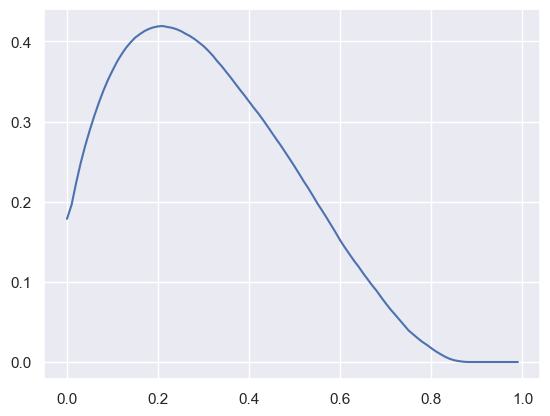

In [134]:
plt.plot(thr_list, f1_list)

In [135]:
idx = f1_list.index(max(f1_list))
idx

21

In [136]:
thr_list[idx]

0.21

In [137]:
y_pred = model.predict_proba(data_test)
y_pred

array([[0.97573505, 0.02426495],
       [0.9290405 , 0.0709595 ],
       [0.84712026, 0.15287974],
       ...,
       [0.99375808, 0.00624192],
       [0.99355261, 0.00644739],
       [0.98882797, 0.01117203]])

In [138]:
y_pred_fin = np.where(y_pred[:, 1] > 0.21, 1, 0)
y_pred_fin

array([0, 0, 0, ..., 0, 0, 0])

In [139]:
prediction = data_test.reset_index()
prediction = prediction[['product_id', 'user_id']]
prediction["reordered"] = y_pred_fin
prediction.head(5)

,product_id,user_id,reordered
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [140]:
# predict
orders_test = orders[orders.eval_set=='test']
prediction = prediction.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left')
prediction.head(25)

,product_id,user_id,reordered,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568
5,9387,3,1,2774568
6,12845,3,0,2774568
7,14992,3,0,2774568
8,15143,3,0,2774568
9,16797,3,0,2774568


In [141]:
prediction['product_id'] = prediction.product_id.astype(int)
prediction = prediction.drop('user_id', axis=1)
prediction.head()

,product_id,reordered,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


## Submit

In [142]:
d = dict()
for row in prediction.itertuples():
    if row.reordered == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in prediction.order_id:
    if order not in d:
        d[order] = 'None'

In [143]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,9387 17668 18599 21903 22035 39190 43961 47766
1,1528013,8424 21903 38293
2,1376945,8309 13176 14947 27959 28465 34658 35948 42585...
3,1356845,7076 10863 11520 13176 14992
4,2161313,196 10441 11266 12427 14715 27839 37710


In [144]:
# 제출하기 위해 csv 파일로 저장합니다.
file_name = "market/submit_HistGradientBoosting.csv"
sub.to_csv(file_name, index=False)
pd.read_csv(file_name).head(2)

,order_id,products
0,2774568,9387 17668 18599 21903 22035 39190 43961 47766
1,1528013,8424 21903 38293
